# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [2]:
# Useful modules
import math
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int32(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    # contrôle du cmap pour la couleur
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*agrandissement_v, plSize[1]*agrandissement_h))
    plt.show()

def thresholdImage(I,s):
    """ Array*int -> Array """
    J = I.copy()
    n,m = I.shape
    for i in range(n):
        for j in range(m):
            if(J[i,j]<s):
                J[i,j]=0
    return J

def imagePad(I,h):
    res = np.zeros((I.shape[0]+ h - 1, I.shape[1] + h - 1))
    for i in range((h//2),(h//2) + I.shape[0]):
        for j in range((h//2),(h//2) + I.shape[1]):
            res[i,j] = I[i-(h//2),j-(h//2)]
    return res

# open lena
lena = np.array(Image.open('img/lena.png'))

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [4]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    # matrice des gradients
    
    Sx = np.array([ [1, 0, -1], 
                    [2, 0, -2], 
                    [1, 0, -1]])

    Sy = np.array([ [ 1,  2,  1], 
                    [ 0,  0,  0], 
                    [-1, -2, -1]])
    
    Qx = np.rot90(np.rot90(Sx))
    Qy = np.rot90(np.rot90(Sy))
    
    Ix = convolve2d(I, Qx, 'same')
    Iy = convolve2d(I, Qy, 'same')
    
    # for i in range(G.shape[0]):
    #     for j in range(G.shape[1]):
    #         G[i, j] = math.sqrt(Ix[i, j]**2 + Iy[i, j]**2)
    
    G = np.sqrt(Ix**2 + Iy**2)
        
    return (thresholdImage(G,s))

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [5]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    L = np.array([  [0,  1,  0], 
                    [1, -4,  1], 
                    [0,  1,  0]])
    
    Lap = convolve2d(I, L, 'same')
    Lap_pad = imagePad(Lap, 3)
    n, m = Lap_pad.shape
    LapDone = np.zeros(I.shape)
    
    for x in range(1,n-1):
        for y in range(1,m-1):
            voisinage = Lap_pad[x-1:x+2, y-1:y+2]
            tmpMax = np.max(voisinage)
            tmpMin = np.min(voisinage)
            
            if tmpMax > 0 and tmpMin < 0 and (tmpMax - tmpMin) > s:
                LapDone[x-1, y-1] = 1
            else:
                LapDone[x-1, y-1] = 0
    
    return LapDone

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

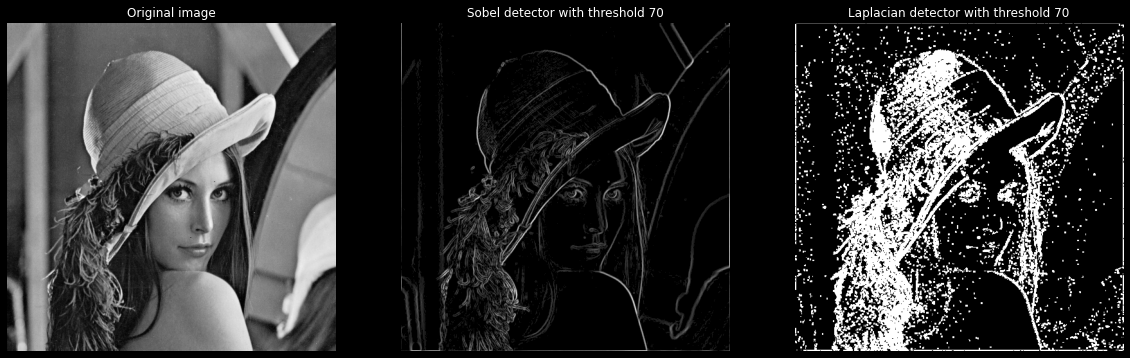

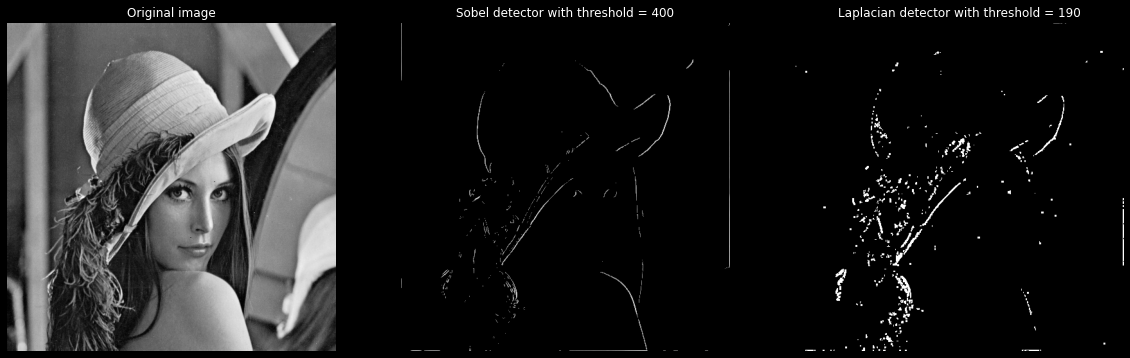

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].imshow(lena, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(SobelDetector(lena, 70), cmap='gray')
axes[1].set_title('Sobel detector with threshold 70')
axes[2].imshow(LaplacianDetector(lena, 70), cmap='gray')
axes[2].set_title('Laplacian detector with threshold 70')
for ax in axes:
    ax.axis('off')

plt.show()

# On cherche un seuil interresant pour ne recuperer que la forme du chapeau 

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].imshow(lena, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(SobelDetector(lena, 400), cmap='gray')
axes[1].set_title('Sobel detector with threshold = 400')
axes[2].imshow(LaplacianDetector(lena, 190), cmap='gray')
axes[2].set_title('Laplacian detector with threshold = 190')
for ax in axes:
    ax.axis('off')

plt.show()

# les deux decteurs semble effetuer un bon travail de dectection des bordures et permettent de faire ressortir les formes 
# générals. Le decteur Sobel semble en revanche lui plus rapide et plus simple et est moins "poluer" par des pixels 
# que le Laplacian.

# **Interprétation :**

Le filtre de Sobel est un filtre de premier ordre, il détecte les bords en calculant le gradient de l'image. Le filtre de Laplacien est un filtre de second ordre, il détecte les bords en calculant la dérivée seconde de l'image. Le filtre de Sobel est plus sensible au bruit que le filtre de Laplacien. Le filtre de Sobel est plus précis que le filtre de Laplacien. Le filtre de Sobel est plus efficace que le filtre de Laplacien.

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

In [8]:
def OrientationTools(I):
    """ Array*double -> Array*double,Array*double,Array*double 
        Cette fonctions nous donne les outils pour calculer/utiliser la fonction orientation
    """
    Sx = np.array([ [1, 0, -1], 
                    [2, 0, -2], 
                    [1, 0, -1]])

    Sy = np.array([ [ 1,  2,  1], 
                    [ 0,  0,  0], 
                    [-1, -2, -1]])
    
    Qx = np.rot90(np.rot90(Sx))
    Qy = np.rot90(np.rot90(Sy))
    
    Ix = convolve2d(I, Qx, 'same')
    Iy = convolve2d(I, Qy, 'same')
    
    G = np.sqrt(Ix**2 + Iy**2)
    return Ix, Iy, G

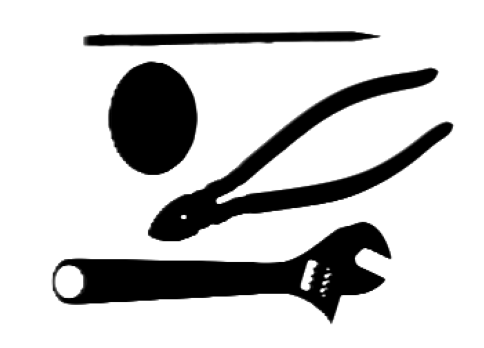

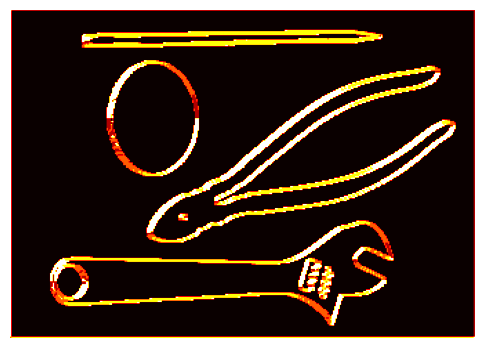

In [7]:
tools = np.array(Image.open('img/tools.png'))
imshow(tools)
Ix, Iy, G = OrientationTools(tools)
Ori = orientation(Ix, Iy, G)
imshow_hot(Ori)

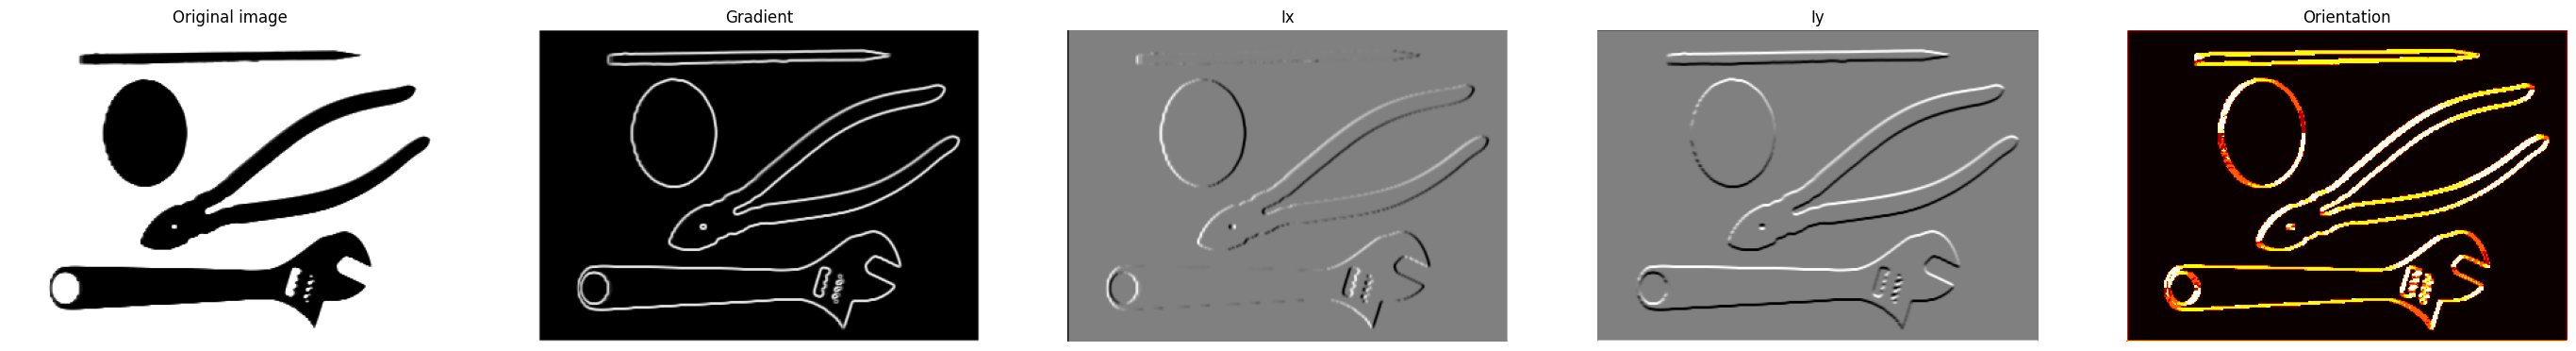

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(35, 10))
axes[0].imshow(tools, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(G, cmap='gray')
axes[1].set_title('Gradient')
axes[2].imshow(Ix, cmap='gray')
axes[2].set_title('Ix')
axes[3].imshow(Iy, cmap='gray')
axes[3].set_title('Iy')
axes[4].imshow(Ori, cmap='hot')
axes[4].set_title('Orientation')
for ax in axes:
    ax.axis('off')
plt.show()

Explain the different values given to a pixel by `orientation()`:

**`orientation()` renvoie un array de même dimension que l'image donnée en paramètre. Chaque élément de l'array corresponds à l'orientation du gradient ou plutot la direction de ce dernier parmis 4 angles: $0$, $\frac\pi4$, $\frac\pi2$ et $\frac{3\pi}4$. On obtient ce résultat avec le gradient de chaque pixel noté $\overrightarrow{G}(P)$. Grâce à ce dernier, on peu calculer la norme du gradient $G(P) = ||\overrightarrow{G}(P)||$ et ce qui nous permet d'obtenir :**
$$
\overrightarrow{g} = \frac{\overrightarrow{G}(P)}{G(P)}
$$
**La direction**

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [9]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    n, m = Ig.shape
    R, Q = 0, 0
    IgPad = imagePad(Ig, 3)
    O = np.zeros((n, m))
    for i in range(1, n+1):
        for j in range(1, m+1):
            if(Ior[i-1, j-1] != 0):
                if(Ior[i-1, j-1] == 1):
                    R, Q = IgPad[i+1, j], IgPad[i-1, j]
                elif(Ior[i-1, j-1] == 2):
                    R, Q = IgPad[i+1, j+1], IgPad[i-1, j-1]
                elif(Ior[i-1, j-1] == 3):
                    R, Q = IgPad[i, j+1], IgPad[i, j-1]
                elif(Ior[i-1, j-1] == 4):
                    R, Q = IgPad[i-1, j+1], IgPad[i+1, j-1]
                
                O[i-1, j-1] = Ig[i-1, j-1] > R and Ig[i-1, j-1] > Q
    return O
            

# imshow(nms(G, Ori))

In [10]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    n, m = Ig.shape
    R, Q = 0, 0
    IgPad = imagePad(Ig, 3)
    O = np.zeros((n, m))
    not_zero_indices = np.nonzero(Ior)
    not_zero = Ior[not_zero_indices]

    for ind, nonzero in enumerate(not_zero):
        i, j = not_zero_indices[0][ind], not_zero_indices[1][ind]
        if(nonzero == 1):
            R, Q = IgPad[i+1, j], IgPad[i-1, j]
        elif(nonzero == 2):
            R, Q = IgPad[i+1, j+1], IgPad[i-1, j-1]
        elif(nonzero == 3):
            R, Q = IgPad[i, j+1], IgPad[i, j-1]
        elif(nonzero == 4):
            R, Q = IgPad[i-1, j+1], IgPad[i+1, j-1]
        
        O[i-1, j-1] = Ig[i-1, j-1] > R and Ig[i-1, j-1] > Q

        #  résultat interetant mais pas le bon
        # O[i, j] = Ig[i, j] > R and Ig[i, j] > Q
    return O

# imshow(nms(G, Ori))

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


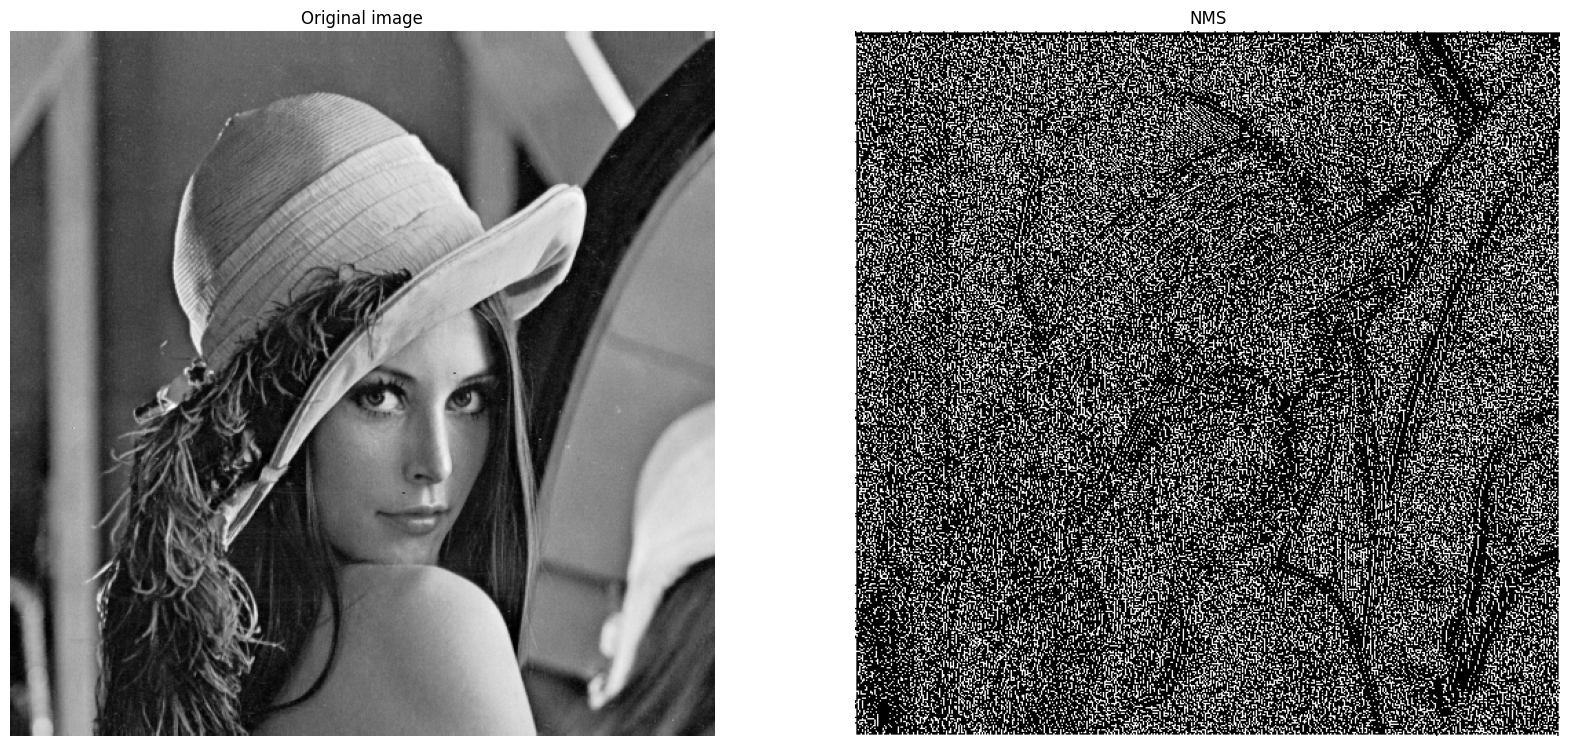

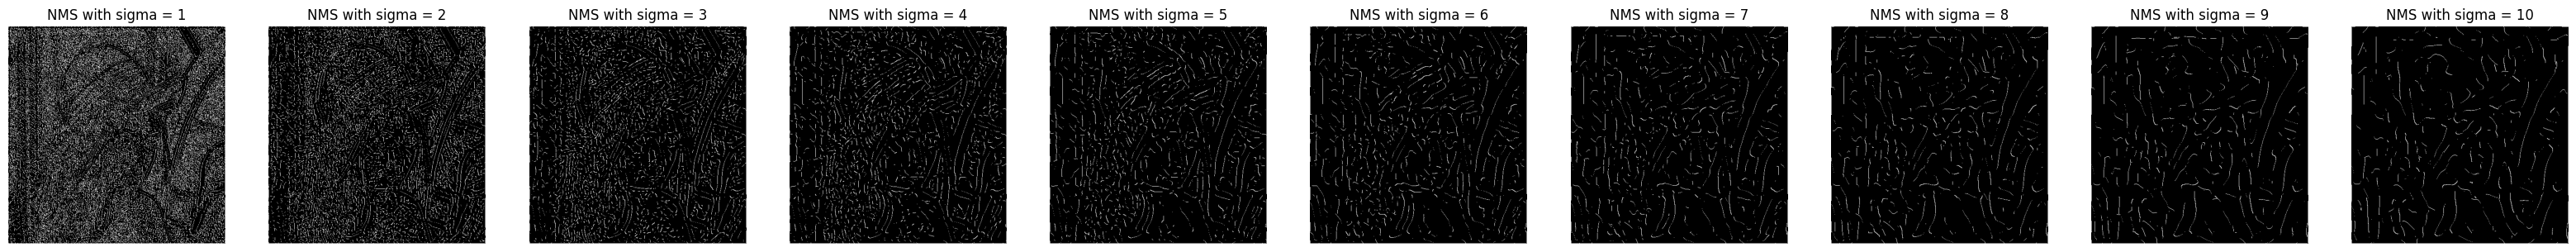

In [11]:
Lx, Ly, Lg = OrientationTools(lena)
lenaOri = orientation(Lx, Ly, Lg)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(lena, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(nms(Lg, lenaOri), cmap='gray')
axes[1].set_title('NMS')
for ax in axes:
    ax.axis('off')

plt.show()

fig, axes = plt.subplots(1, 10, figsize=(40, 10))
for i in range(10):
    gaussLena = convolve2d(lena,gaussianKernel(i+1), 'same')
    Lx, Ly, Lg = OrientationTools(gaussLena)
    lenaOri = orientation(Lx, Ly, Lg)
    axes[i].imshow(nms(Lg, lenaOri), cmap='gray')
    axes[i].set_title('NMS with sigma = ' + str(i+1))
    axes[i].axis('off')

plt.show()

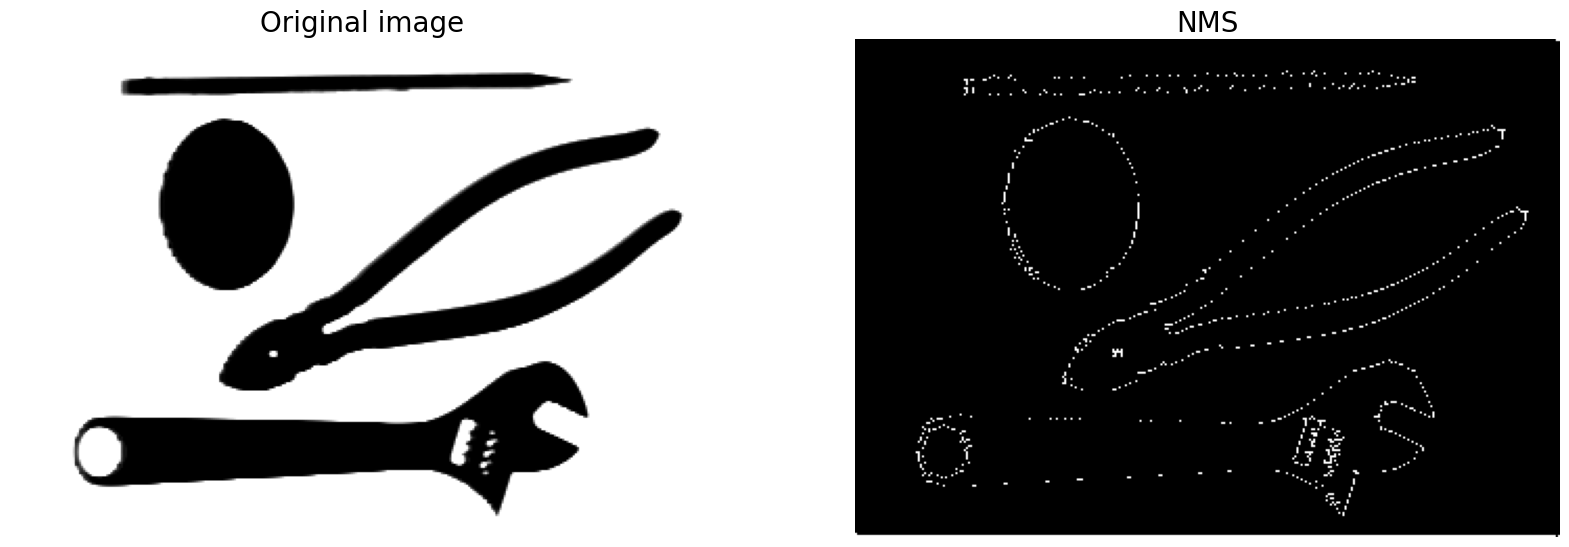

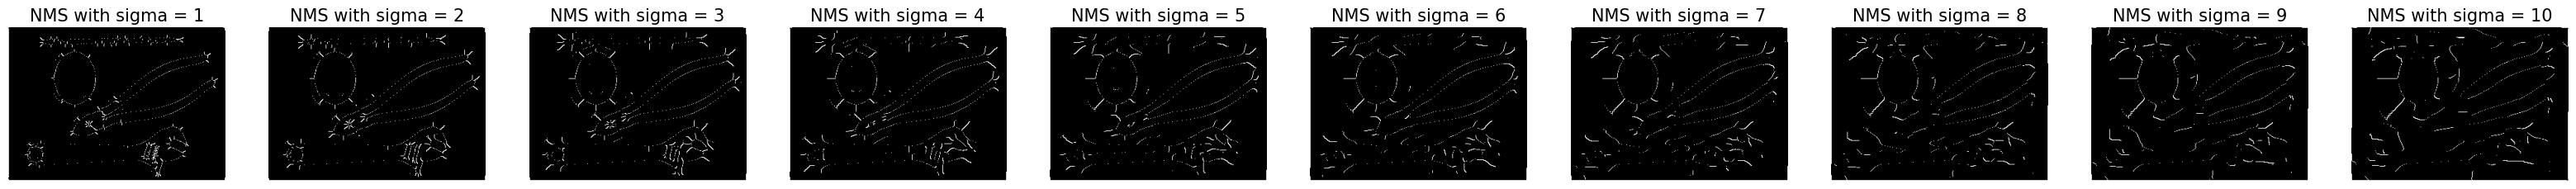

In [12]:
Lx, Ly, Lg = OrientationTools(tools)
toolsOri = orientation(Lx, Ly, Lg)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(tools, cmap='gray')
axes[0].set_title('Original image', fontsize=20)
axes[1].imshow(nms(Lg, toolsOri), cmap='gray')
axes[1].set_title('NMS', fontsize=20)
for ax in axes:
    ax.axis('off')

plt.show()

fig, axes = plt.subplots(1, 10, figsize=(40, 10))
for i in range(10):
    gaussTools = convolve2d(tools,gaussianKernel(i+1), 'same')
    Lx, Ly, Lg = OrientationTools(gaussTools)
    toolsOri = orientation(Lx, Ly, Lg)
    axes[i].imshow(nms(Lg, toolsOri), cmap='gray')
    axes[i].set_title('NMS with sigma = ' + str(i+1), fontsize=15)
    axes[i].axis('off')

plt.show()

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

**La valeur de "l'affinage" $\sigma$ influe fortement sur la détections des bords. En effet, on vois qu'avec un $\sigma$ élevé (7) on arrive ne distinguer que quelques bordure "valide" sur lena, et sur tools, la detection de bord est brouiller. Sur les contours de l'image, l'affinage a fait emerger des bords inexistant sur l'image initial. Un $\sigma$ trop fort altère fortement la detection de bord. Avec un $\sigma$ plus faible, Les formes générals de du chapeau et du visage peuvent etre bien mieux distingués. Pour Tools, on perd en précision sur certains des contours. En conclucion, uniformiser une image peu etre pratique dans certains cas particuliers avec des images avec des basse fréquence.**

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

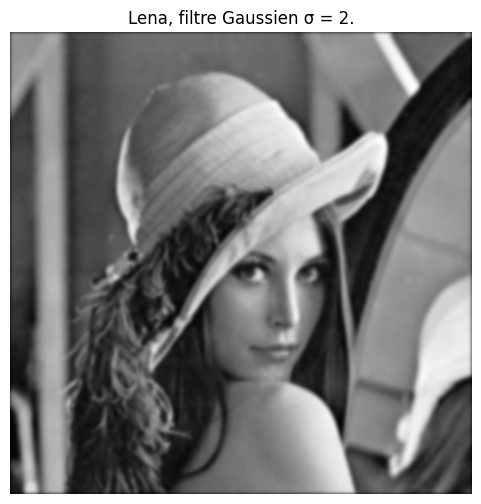

In [13]:
gaussLena2 = convolve2d(lena,gaussianKernel(2.), 'same')
imshow(gaussLena2,"Lena, filtre Gaussien σ = 2.")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

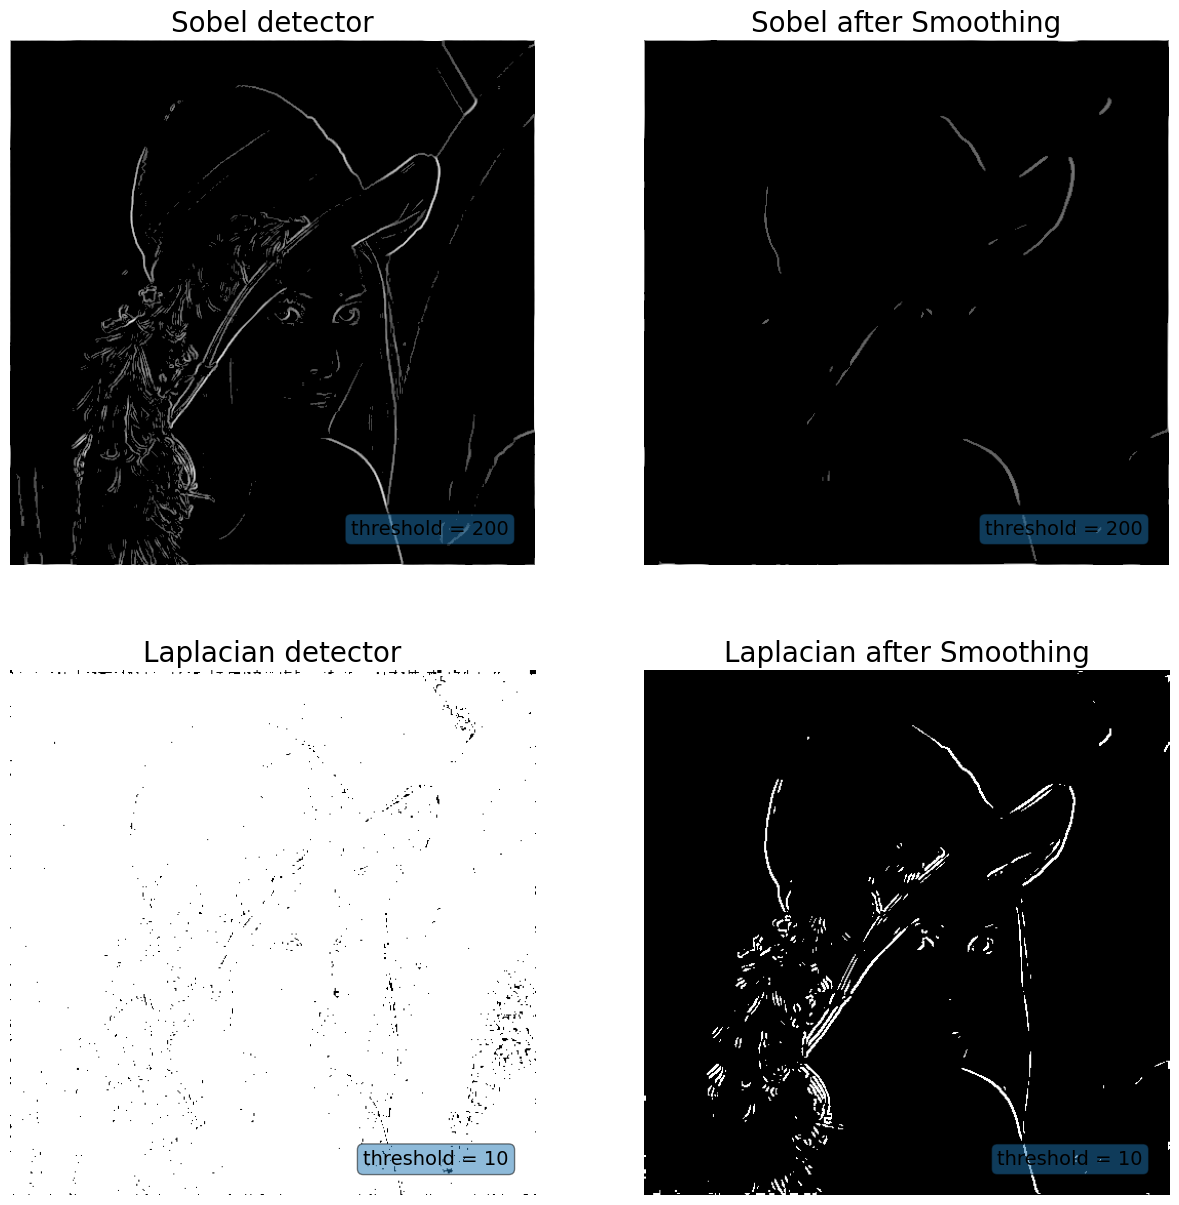

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# Sobel filter
axes[0, 0].imshow(SobelDetector(lena,200), cmap='gray')
axes[0, 0].set_title('Sobel detector', fontsize=20)
axes[0, 0].text(0.95, 0.05, 'threshold = 200', transform=axes[0, 0].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))
axes[0, 1].imshow(SobelDetector(gaussLena2,200), cmap='gray')
axes[0, 1].set_title("Sobel after Smoothing", fontsize=20)
axes[0, 1].text(0.95, 0.05, 'threshold = 200', transform=axes[0, 1].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))

# Laplacian filter
axes[1, 0].imshow(LaplacianDetector(lena,10), cmap='gray')
axes[1, 0].set_title('Laplacian detector', fontsize=20)
axes[1, 0].text(0.95, 0.05, 'threshold = 10', transform=axes[1, 0].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))
axes[1, 1].imshow(LaplacianDetector(gaussLena2,10), cmap='gray')
axes[1, 1].set_title("Laplacian after Smoothing", fontsize=20)
axes[1, 1].text(0.95, 0.05, 'threshold = 10', transform=axes[1, 1].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))

for ax in axes:
    for a in ax:
        a.axis('off')

plt.show()


**On garde le même threshold pour pouvoir comparer proprement les deux filtre. Attention les images que l'on etudie particulièrement 
ici sont sont "Sobel after Smoothing" et "Laplacian after Smoothing"
La principal différence entre les deux filtres est la présence des plumes ( zone de hautes fréquence ) avec le Laplacian alors que avec Sobel, les plumes 
ne sont plus présente. Sur les deux, on peux voir encore les yeux et les formes de l'épaule et le chapeau.**

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

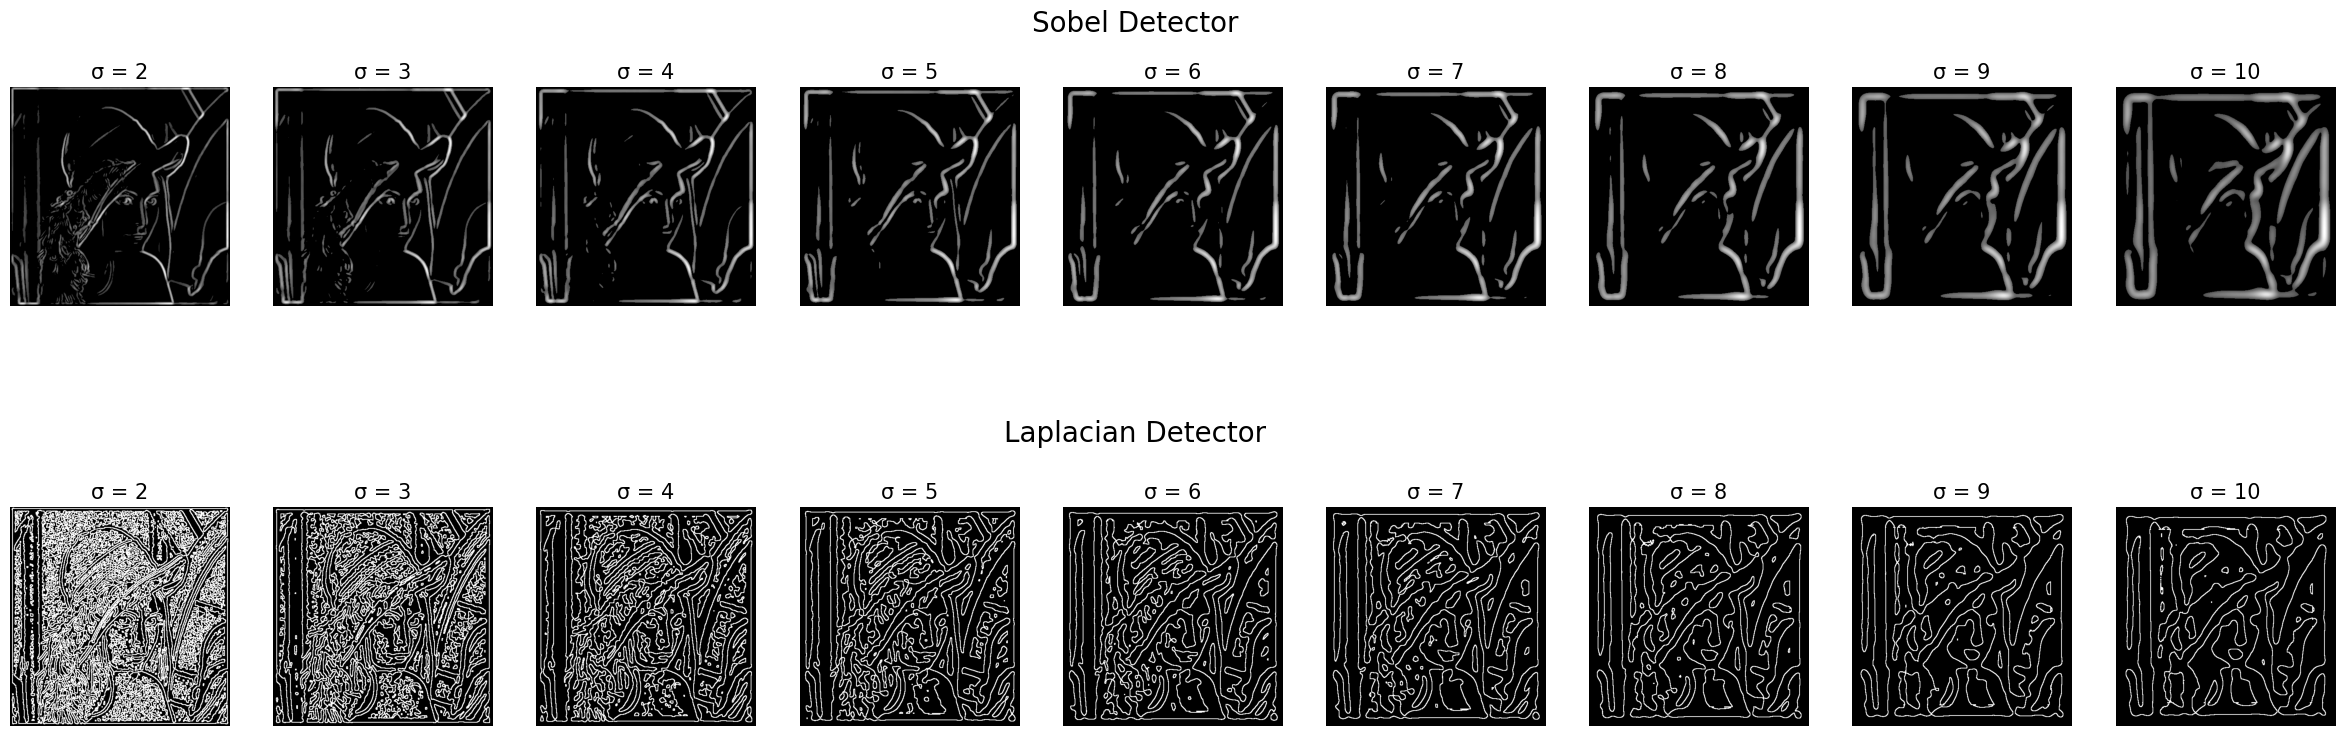

In [15]:
fig, axes = plt.subplots(2, 9, figsize=(30, 10))

fig.text(0.5, 0.87, 'Sobel Detector', ha='center', fontsize=20)
fig.text(0.5, 0.46, 'Laplacian Detector', ha='center', fontsize=20)
for i in range(2,11):
    ax = axes[0, i-2]
    gaussLenaN = convolve2d(lena,gaussianKernel(i))
    ax.imshow(SobelDetector(gaussLenaN,70-i*5), cmap='gray')
    ax.set_title('σ = ' + str(i), fontsize=15)
    ax.axis('off')

for i in range(2,11):
    ax = axes[1, i-2]
    gaussLenaN = convolve2d(lena,gaussianKernel(i))
    ax.imshow(LaplacianDetector(gaussLenaN,5-i*3), cmap='gray')
    ax.set_title('σ = ' + str(i), fontsize=15)
    ax.axis('off')

plt.show()

# **Interprétation :**
**On peux voir avec le filtre de Sobel que plus $\sigma$ est grand, plus un cadre se dessine sur la bordure de l'image. Ce filtre 
plus grossiser pourrais permettre de reperer les forme les plus marqués de facon plus grossière.
Avec le filtre de Sobel, avec un faible $\sigma$, les contoures sont bien démarqués et les zones avec du bruits sont comme des
fils entre-mélé. Cela pourrais permettre de determiner proprement les zones intérieure des objet que le cherche a détourer.
Et plus sigma augmente plus ces fil disparaisent et laisse place a des contoures grossier. Encore un fois ici, l'étape 
d'affinage crée un cadre sur les bords de l'image.**

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

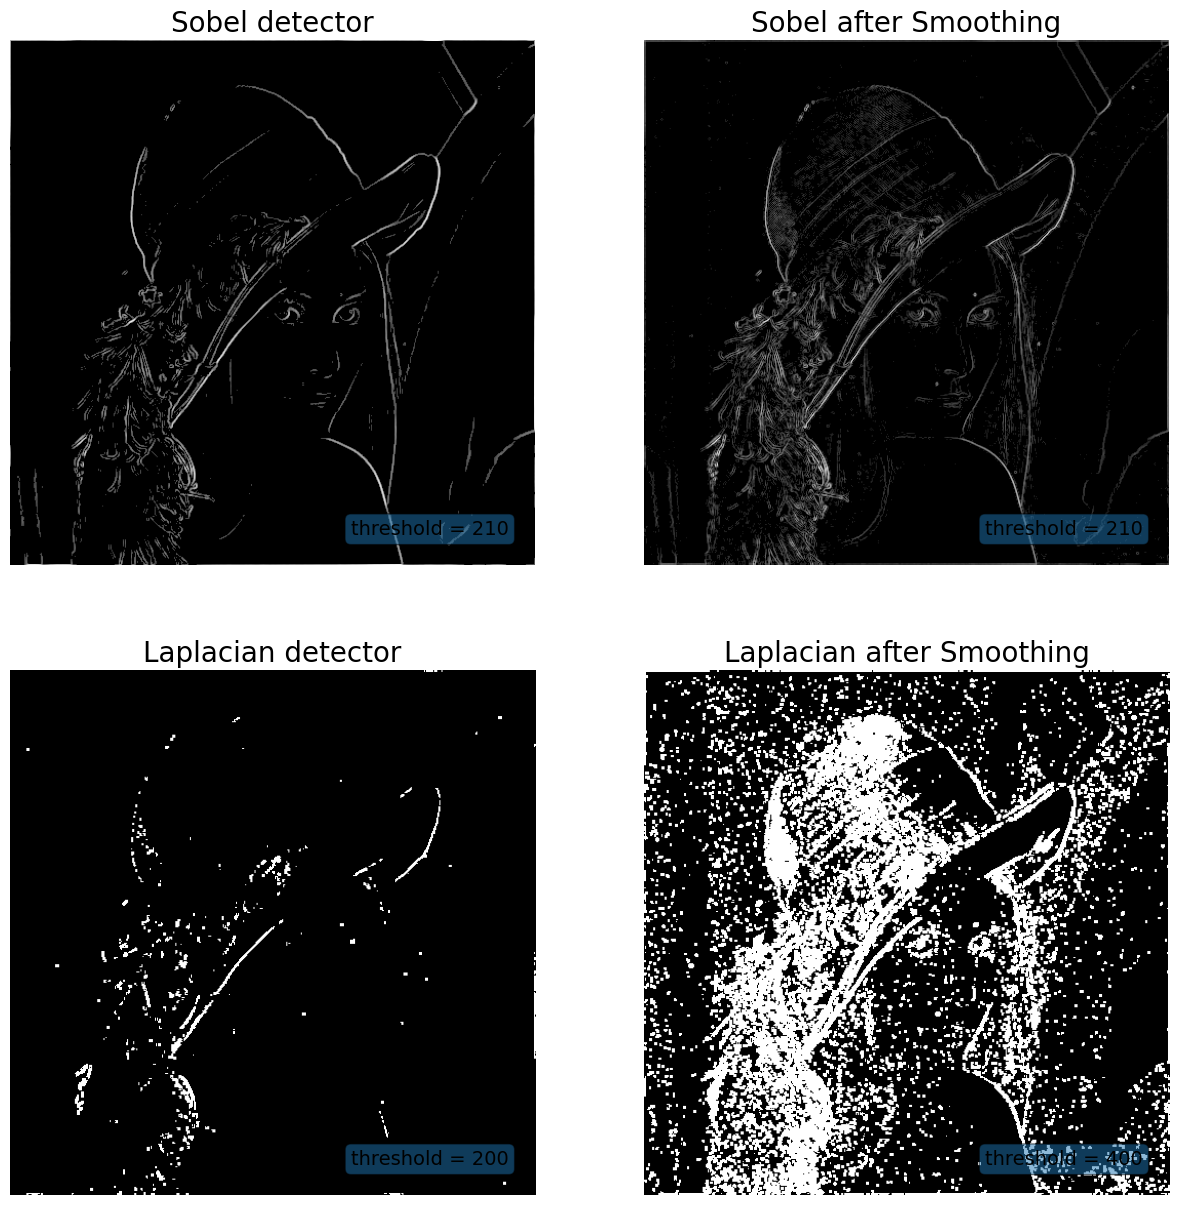

In [16]:
# constrast enhancer filter
CEF = np.array([[ 0,  -1,  0], 
                [-1,   5, -1],
                [ 0,  -1,  0]]) 

lenaSmooth = convolve2d(lena, CEF, 'same')

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# Sobel filter
axes[0, 0].imshow(SobelDetector(lena,210), cmap='gray')
axes[0, 0].set_title('Sobel detector', fontsize=20)
axes[0, 0].text(0.95, 0.05, 'threshold = 210', transform=axes[0, 0].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))
axes[0, 1].imshow(SobelDetector(lenaSmooth,210), cmap='gray')
axes[0, 1].set_title("Sobel after Smoothing", fontsize=20)
axes[0, 1].text(0.95, 0.05, 'threshold = 210', transform=axes[0, 1].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))

# Laplacian filter
axes[1, 0].imshow(LaplacianDetector(lena,200), cmap='gray')
axes[1, 0].set_title('Laplacian detector', fontsize=20)
axes[1, 0].text(0.95, 0.05, 'threshold = 200', transform=axes[1, 0].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))
axes[1, 1].imshow(LaplacianDetector(lenaSmooth,400), cmap='gray')
axes[1, 1].set_title("Laplacian after Smoothing", fontsize=20)
axes[1, 1].text(0.95, 0.05, 'threshold = 400', transform=axes[1, 1].transAxes, fontsize=14, horizontalalignment='right', verticalalignment='bottom', \
                bbox=dict(boxstyle='round', alpha=0.5))

for ax in axes:
    for a in ax:
        a.axis('off')

plt.show()

**Pour le filtre de Sobel, L'ajout de contraste permet de faire entre autre de faire ressortir les yeux et les textures du chapeau
et des plumes.
Pour le filtre de Laplace, Les zones mise en avant semble etre les zones où la luminosité est plus faible (zones d'ombre
ou plus sombre par leur couleur).**

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

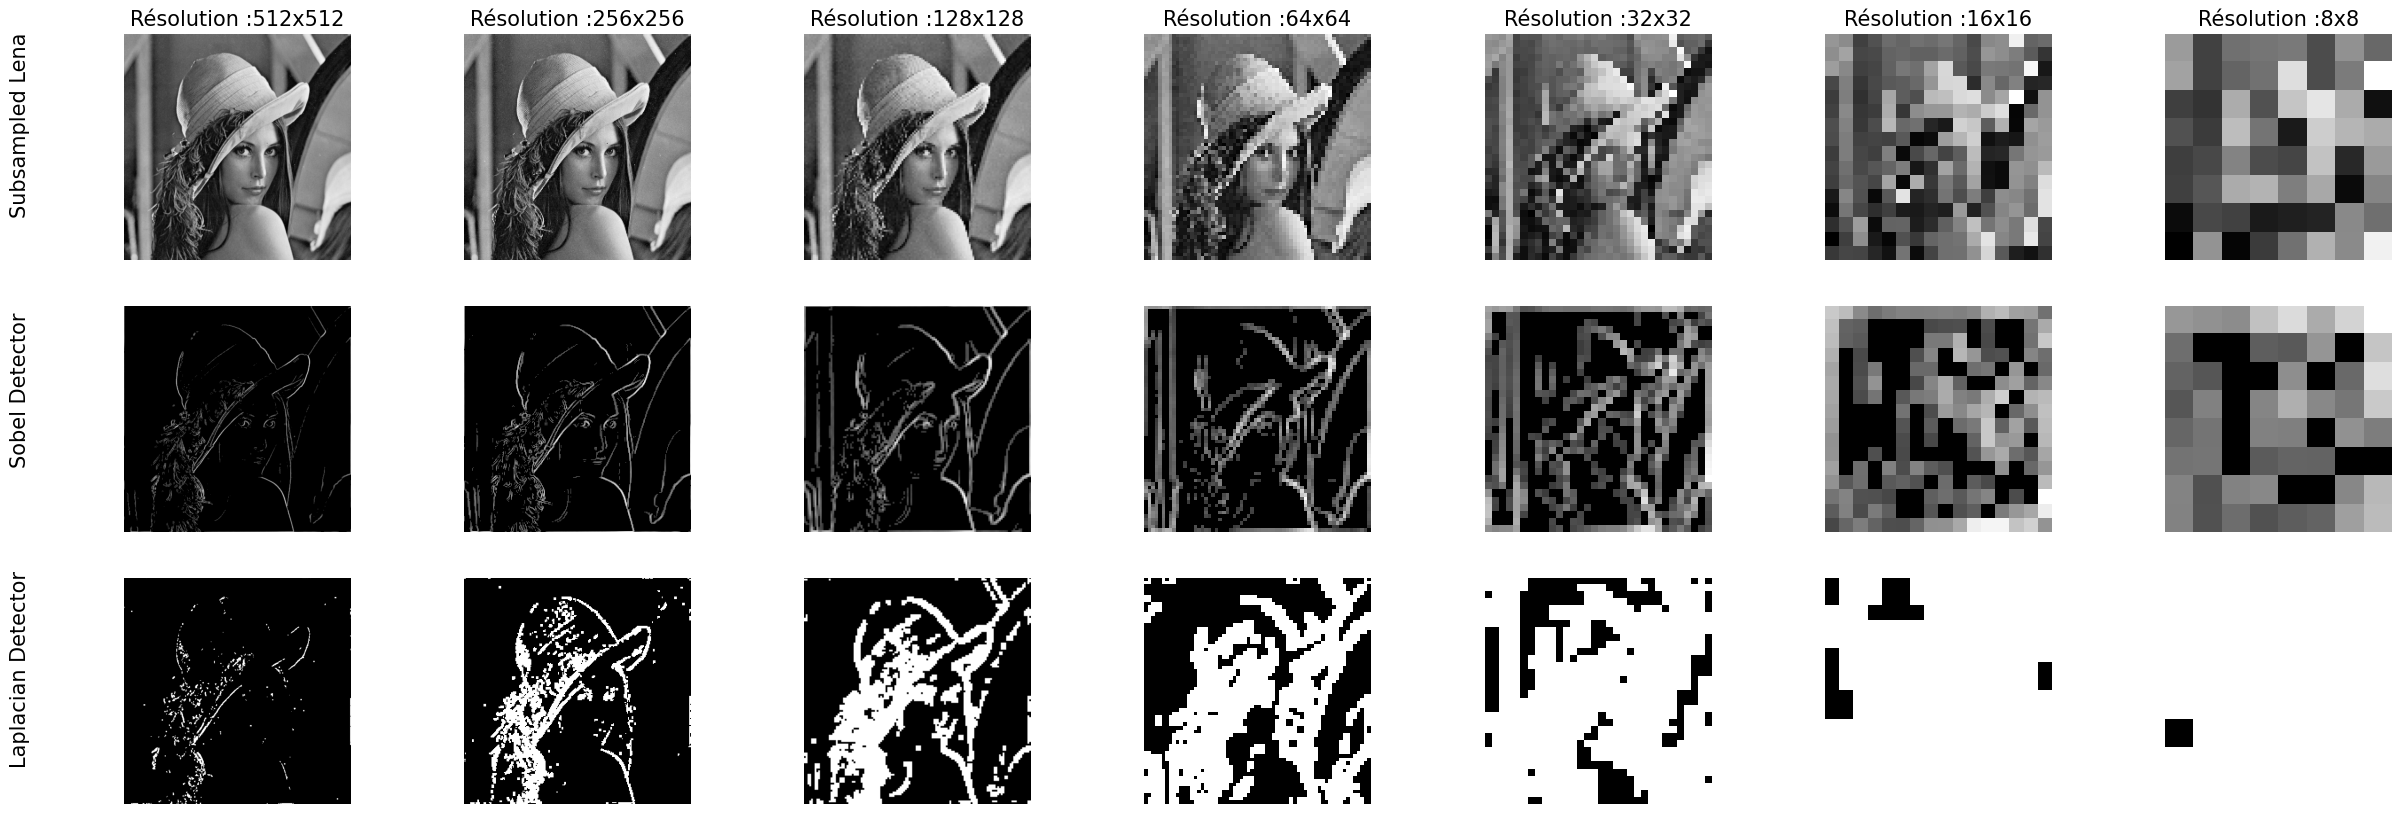

In [17]:
def subSample2(I): 
    """SubSample 2 times a given picture"""
    return I[::2,::2]

subSampleLena = lena
fig, axes = plt.subplots(3, 7, figsize=(30, 10))
fig.text(0.1, 0.70, 'Subsampled Lena', ha='center', rotation = 90, fontsize=15)
fig.text(0.1, 0.45, 'Sobel Detector', ha='center', rotation = 90, fontsize=15)
fig.text(0.1, 0.15, 'Laplacian Detector', ha='center', rotation = 90, fontsize=15)

for i in range(len(axes[0])):
    n, m = subSampleLena.shape

    ax = axes[0, i]
    ax.imshow(subSampleLena, cmap='gray')
    ax.set_title("Résolution :" + str(n) + "x" + str(m), fontsize=15)
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(SobelDetector(subSampleLena,200), cmap='gray')
    ax.axis('off')

    ax = axes[2, i]
    ax.imshow(LaplacianDetector(subSampleLena,180) , cmap='gray')
    ax.axis('off')

    subSampleLena = subSample2(subSampleLena)

plt.show()

# **Interprétation :**
**En diminuant la résolution, le filtre de Sobel semble plus efficace et permet de récuperé les formes interressantes de l'image, 
alors que le Laplacian perd rapidement en précision et nous permet de visualiser les formes des object plus grosièrement
A partir d'une résolution 32x32 les deux filtres ne nous fournissent plus d'image exploitable.**

# partie Bonus
travail sur les effets d'un filtre gaussien avant l'application de filtre de **Sobel et Laplacian**

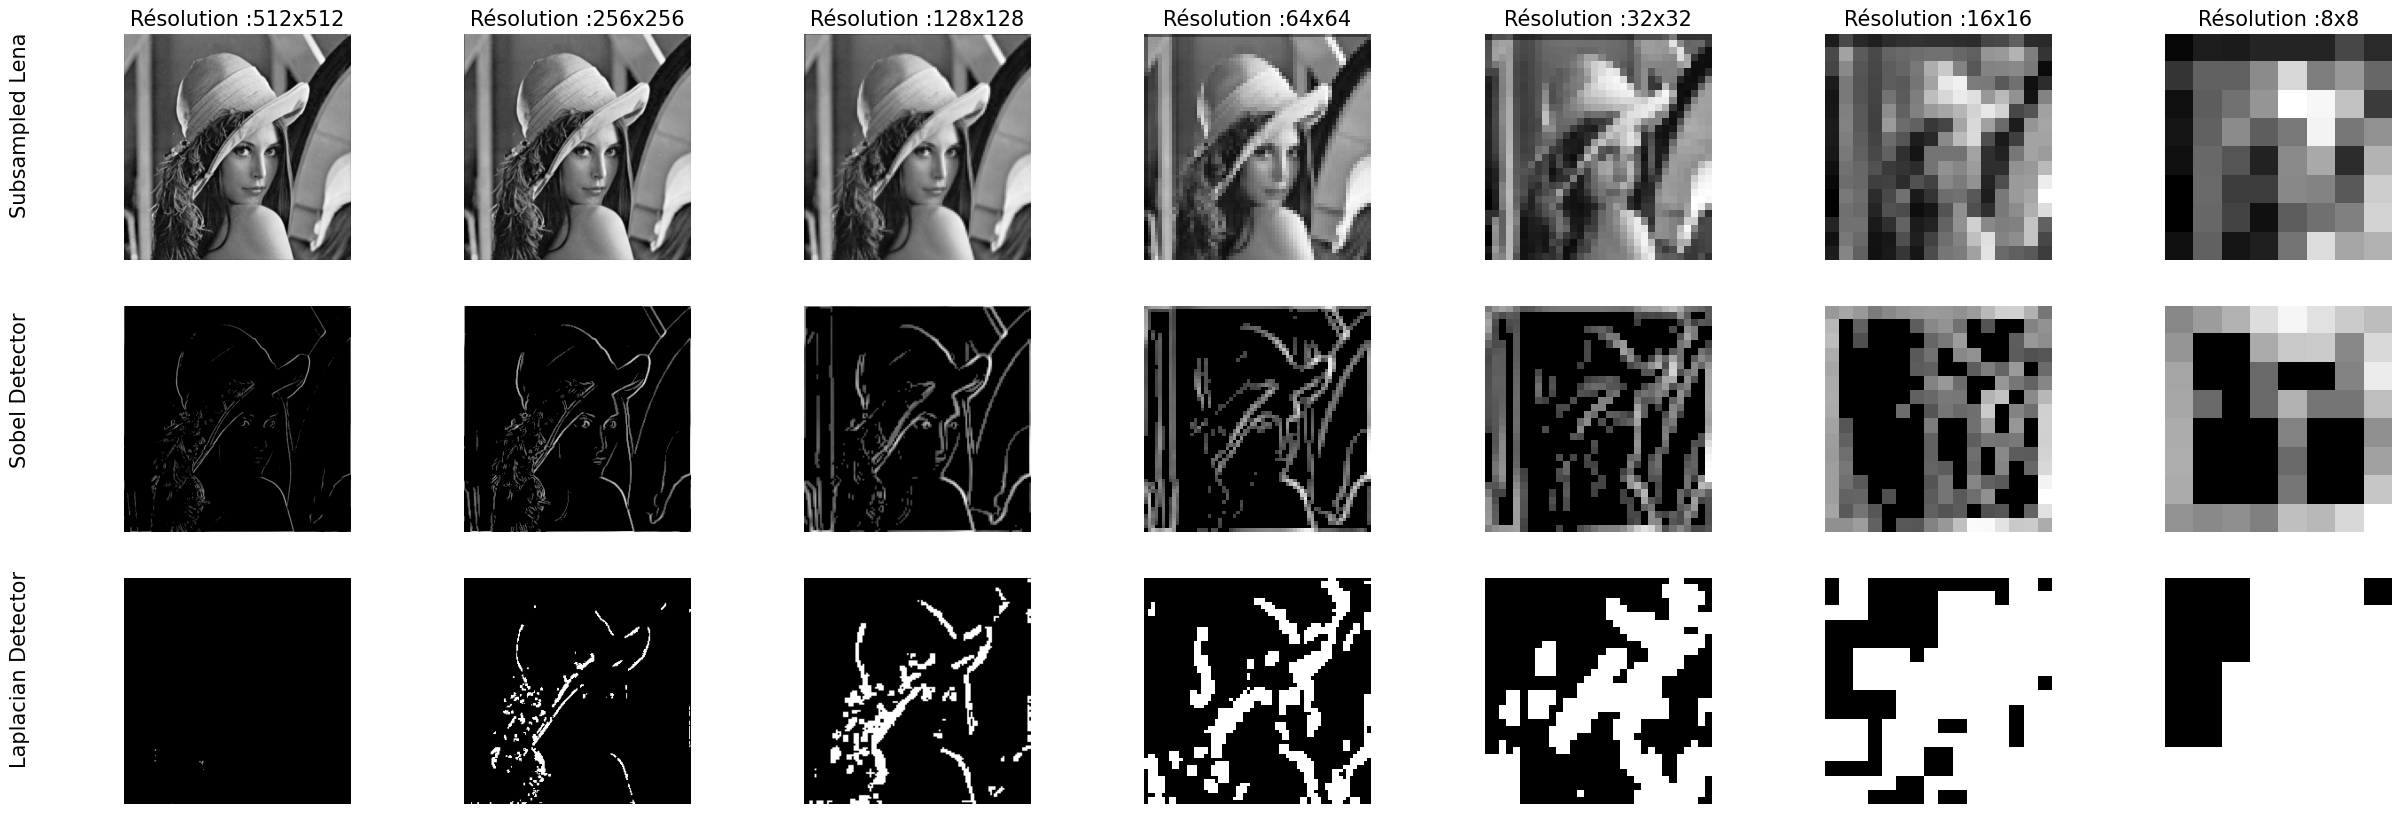

In [13]:
def subSample2(I): 
    """SubSample 2 times a given picture"""
    return I[::2,::2]

subSampleLena = convolve2d(lena, gaussianKernel(0.625), 'same')
fig, axes = plt.subplots(3, 7, figsize=(30, 10))
fig.text(0.1, 0.70, 'Subsampled Lena', ha='center', rotation = 90, fontsize=15)
fig.text(0.1, 0.45, 'Sobel Detector', ha='center', rotation = 90, fontsize=15)
fig.text(0.1, 0.15, 'Laplacian Detector', ha='center', rotation = 90, fontsize=15)

for i in range(len(axes[0])):
    n, m = subSampleLena.shape

    ax = axes[0, i]
    ax.imshow(subSampleLena, cmap='gray')
    ax.set_title("Résolution :" + str(n) + "x" + str(m), fontsize=15)
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(SobelDetector(subSampleLena,200), cmap='gray')
    ax.axis('off')

    ax = axes[2, i]
    ax.imshow(LaplacianDetector(subSampleLena,180), cmap='gray')
    ax.axis('off')

    subSampleLena = subSample2(convolve2d(subSampleLena, gaussianKernel(0.625), 'same'))

plt.show()

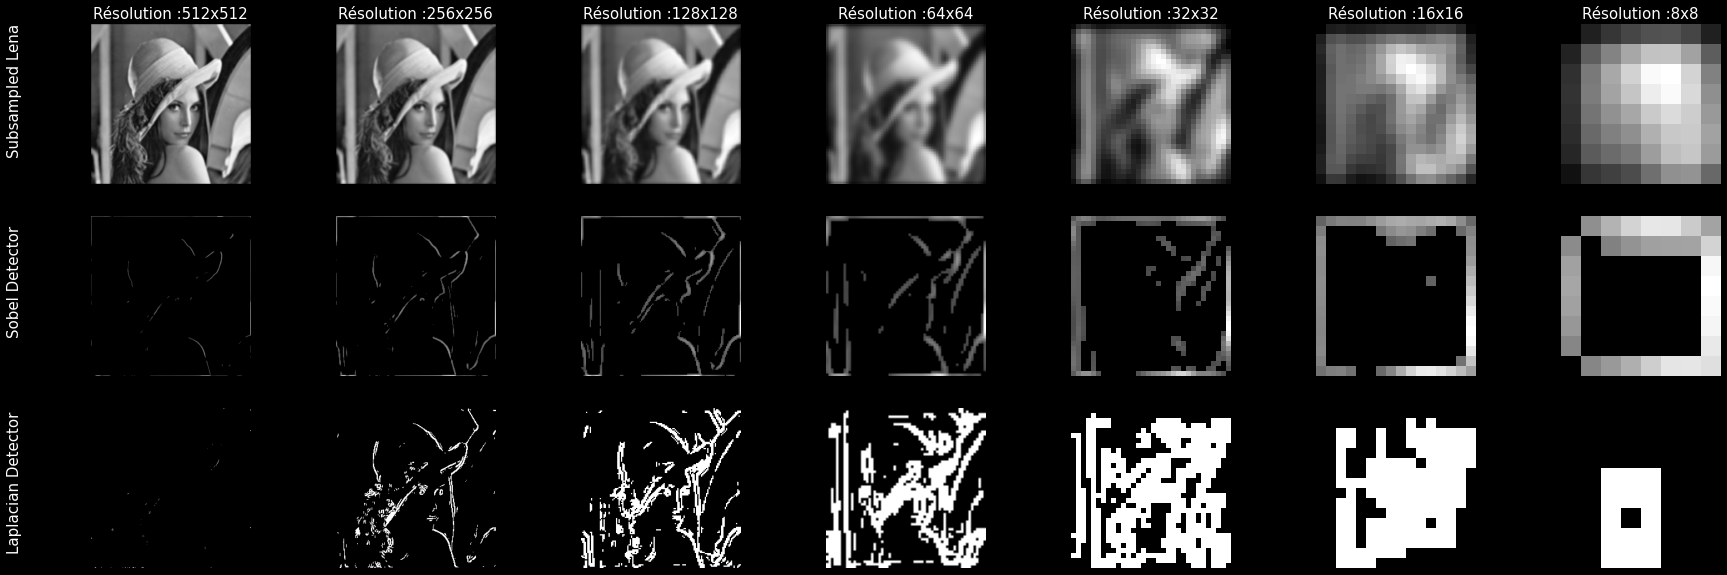

In [11]:
def subSample2(I): 
    """SubSample 2 times a given picture"""
    return I[::2,::2]

subSampleLena = convolve2d(lena, gaussianKernel(2), 'same')
fig, axes = plt.subplots(3, 7, figsize=(30, 10))
fig.text(0.1, 0.70, 'Subsampled Lena', ha='center', rotation = 90, fontsize=15)
fig.text(0.1, 0.45, 'Sobel Detector', ha='center', rotation = 90, fontsize=15)
fig.text(0.1, 0.15, 'Laplacian Detector', ha='center', rotation = 90, fontsize=15)

for i in range(len(axes[0])):
    n, m = subSampleLena.shape

    ax = axes[0, i]
    ax.imshow(subSampleLena, cmap='gray')
    ax.set_title("Résolution :" + str(n) + "x" + str(m), fontsize=15)
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(SobelDetector(subSampleLena,200), cmap='gray')
    ax.axis('off')

    ax = axes[2, i]
    ax.imshow(LaplacianDetector(subSampleLena,20), cmap='gray')
    ax.axis('off')

    subSampleLena = subSample2(convolve2d(subSampleLena, gaussianKernel(2), 'same'))

plt.show()